## Stock Trading Bot Calculator using Custom CNN model

### Introduction

In this project, we explore the use of advanced deep learning techniques, specifically convolutional neural networks (CNNs) and pre-trained models such as ResNet50, InceptionV3, and DenseNet121, to predict stock prices based on historical market data.

### Project Phases

**Phase 1**: Developing a Custom CNN Model for Stock Price Prediction

We design and implement a custom CNN model to predict stock prices using historical market data. The model is trained to learn patterns in stock price movements and make predictions that can guide trading decisions.


**Phase 2**: Experimenting with Pre-Trained Models for Stock Price Prediction

We explore the use of pre-trained models, fine-tuned to predict stock prices. By leveraging the power of transfer learning, we compare the performance of these models to our custom-built CNN.



### Project Team

- **Usama Mohiuddin**: 212090340
- **Ranjot Sandhu**: 169020301
- **Rupesh Rangwani**: 169016076
- **Rishubh Gusain**: 169044443


In [1]:
# Import necessary libraries
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter, MaxNLocator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gradio as gr
import matplotlib.animation as animation
from PIL import Image


## Phase 1: Custom CNN Model Design and Implementation

### CNN Model

To predict stock prices, we developed a custom CNN model using TensorFlow and Keras API. The model is designed to identify patterns in historical stock data and forecast future price movements. It includes convolutional layers, pooling layers, and dense layers to process the data and make predictions.

### Model Architecture

**Conv1D Layers**: Extract features from the input time series data to identify trends and fluctuations in stock prices.

**MaxPooling1D Layers**: Reduce the dimensionality of feature maps, lowering computational load and minimizing overfitting. This layer helps the model focus on significant features.

**Flatten Layer**: Converts the 2D feature maps into 1D feature vectors, preparing the data for the fully connected layers.

**Dense Layers**: Fully connected layers that combine the extracted features to produce the final stock price prediction.

In [2]:
# Function to predict future stock prices using the trained model
def predict_stock_prices(symbol, initial_capital, start_date, end_date):
    global cash, stocks, buy_price, sell_price, final_capital, df, test_df, sequence_length, features, model, buy_count, sell_count

    buy_count = 0
    sell_count = 0

    # Append '.csv' to the symbol to construct the filename
    filename = f"{symbol}.csv"

    # Construct the path to the data file
    data_path = os.path.join('archive', 'stocks', filename)

    # Load the dataset
    df = pd.read_csv(data_path)

    # Ensure correct data types
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Automatically determine the start and end dates of the data
    available_start_date = df.index.min()
    available_end_date = df.index.max()

    # Ensure provided dates are within the available range
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    if start_date < available_start_date or end_date > available_end_date:
        raise ValueError(f"Date range out of bounds. Available range is from {available_start_date.date()} to {available_end_date.date()}")

    # Use the determined date range
    df = df[start_date:end_date]

    # Feature columns and target
    features = ['Open', 'High', 'Low', 'Close', 'Volume']
    target = 'Close'

    # Check if the subset is empty
    if df.empty:
        raise ValueError("DataFrame is empty. Check the date range and ensure the data file contains data for the specified period.")

    # Separate scaler for the 'Close' column
    close_scaler = MinMaxScaler()

    # Normalize the Close prices
    df['Close'] = close_scaler.fit_transform(df[['Close']])

    # Normalize other features
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Create sequences (e.g., using past 30 days to predict the next day)
    sequence_length = 30

    def create_sequences(data, seq_length, features, target):
        sequences = []
        labels = []
        for i in range(len(data) - seq_length):
            sequences.append(data.iloc[i:i + seq_length][features].values)
            labels.append(data.iloc[i + seq_length][target])
        return np.array(sequences), np.array(labels)

    # Split the data into training and testing sets
    train_size = int(len(df) * 0.8)
    train_df = df[:train_size]
    test_df = df[train_size:]

    # Check if the test data is too small, and adjust accordingly
    if len(test_df) <= sequence_length:
        train_df = df
        test_df = df
        sequence_length = max(1, int(len(df) * 0.2))

    # Create sequences
    X_train, y_train = create_sequences(train_df, sequence_length, features, target)
    X_test, y_test = create_sequences(test_df, sequence_length, features, target)

    # Check the shapes of the data
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Ensure the test data is not empty
    if X_test.shape[0] == 0 or y_test.shape[0] == 0:
        raise ValueError("Test data is empty. Increase the size of the dataset or adjust the sequence length.")

    # Define the CNN model
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(features))),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(20, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Reset cash and stocks
    cash = initial_capital
    stocks = 0
    buy_dates = []
    sell_dates = []
    buy_price = None
    sell_price = None

    # Initialize logs
    logs = []
    capital_changes = [f"Initial Capital: ${cash}"]

    # Generate predictions
    df['Predicted_Close'] = np.nan
    for i in range(len(test_df) - sequence_length):
        X_input = test_df.iloc[i:i + sequence_length][features].values
        X_input = X_input.reshape((1, sequence_length, len(features)))
        pred = model.predict(X_input)[0][0]
        df.iloc[train_size + sequence_length + i, df.columns.get_loc('Predicted_Close')] = pred

    # Denormalize the predictions and actuals for accurate plotting
    df['Close'] = close_scaler.inverse_transform(df[['Close']])
    df['Predicted_Close'] = close_scaler.inverse_transform(df[['Predicted_Close']])

    # Calculate classification threshold for buy/sell decisions
    threshold = np.median(df['Predicted_Close'].dropna())

    # Convert prices into binary buy/sell signals
    y_true = (df['Close'] > threshold).astype(int)
    y_pred_binary = (df['Predicted_Close'] > threshold).astype(int)

    # Remove NaN values
    y_true = y_true[~df['Predicted_Close'].isna()]
    y_pred_binary = y_pred_binary[~df['Predicted_Close'].isna()]

    # Calculate True Positive, True Negative, False Positive, False Negative
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()

    # Calculate AUC and AUROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_binary)
    auc_score = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_true, y_pred_binary)

    # Log the quality measures
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    print(f"AUC Score: {auc_score:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")

    # Plot ROC curve
    fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
    ax_roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.legend(loc="lower right")

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_binary)
    fig_pr, ax_pr = plt.subplots(figsize=(8, 6))
    ax_pr.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Precision-Recall Curve')
    ax_pr.legend(loc="lower left")

    # Plot Training & Validation Loss
    fig_loss, ax_loss = plt.subplots(figsize=(8, 6))
    ax_loss.plot(history.history['loss'], label='Training Loss')
    ax_loss.plot(history.history['val_loss'], label='Validation Loss')
    ax_loss.set_title('Training and Validation Loss')
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()

    # Plot confusion matrix
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred_binary), annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_title('Confusion Matrix')
    ax_cm.set_xlabel('Predicted Label')
    ax_cm.set_ylabel('True Label')

    # Initialize data for animation
    dates = []
    close_prices = []
    predicted_prices = []
    buys = {'dates': [], 'prices': []}
    sells = {'dates': [], 'prices': []}

    # Define the buy and sell logic
    df['Min'] = df['Low'][df['Low'] == df['Low'].rolling(window=3, center=True).min()]
    df['Max'] = df['High'][df['High'] == df['High'].rolling(window=3, center=True).max()]

    fig, ax1 = plt.subplots(figsize=(14, 7))
    fig.suptitle('Stock Prices with Buy/Sell Signals', fontsize=16)

    # Plot the closing prices and predicted closing prices
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    date_form = DateFormatter("%Y-%m")
    ax1.xaxis.set_major_formatter(date_form)

    # Add grid lines
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Plot the data with more details
    line, = ax1.plot(df.index, df['Close'], label='Close Prices', color='blue', linewidth=1)
    pred_line, = ax1.plot(df.index, df['Predicted_Close'], label='Predicted Close Prices', linestyle='--', color='orange', linewidth=1)
    buy_scatter = ax1.scatter([], [], marker='^', color='green', label='Buy Signal', s=100)
    sell_scatter = ax1.scatter([], [], marker='v', color='red', label='Sell Signal', s=100)

    # Plot moving averages
    df['SMA9'] = df['Close'].rolling(window=9).mean()
    df['SMA21'] = df['Close'].rolling(window=21).mean()
    ax1.plot(df.index, df['SMA9'], label='SMA 9', color='purple', linewidth=1)
    ax1.plot(df.index, df['SMA21'], label='SMA 21', color='cyan', linewidth=1)

    ax1.legend(loc='upper left')

    # Create a secondary y-axis for the volume bars
    ax2 = ax1.twinx()
    ax2.bar(df.index, df['Volume'], color='blue', alpha=0.3, width=1)
    ax2.grid(False)

    # Set y-axis limits for Volume and Price
    ax1.set_ylim(df['Close'].min(), df['Close'].max())
    ax2.set_ylim(df['Volume'].min(), df['Volume'].max())

    # Format x-axis to show only the major ticks and labels
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=8))

    # Improve y-axis formatting for better readability
    ax1.yaxis.set_major_formatter('${x:,.2f}')

    ax2.get_yaxis().set_visible(False)

    # Function to format volume axis
    def volume_formatter(x, pos):
        if x >= 1e6:
            return f'{x*1e-6:.1f}M'
        elif x >= 1e3:
            return f'{x*1e-3:.1f}K'
        else:
            return f'{x:.0f}'

    ax2.yaxis.set_major_formatter(FuncFormatter(volume_formatter))

    def animate(i):
        global cash, stocks, buy_price, sell_price, final_capital, buy_count, sell_count

        if i >= len(df):
            return

        current_date = df.index[i]
        current_low = df['Low'].iloc[i]
        current_high = df['High'].iloc[i]
        current_close = df['Close'].iloc[i]
        current_pred = df['Predicted_Close'].iloc[i]

        dates.append(current_date)
        close_prices.append(current_close)
        predicted_prices.append(current_pred)

        if not np.isnan(df['Min'].iloc[i]):
            if cash > 0:
                buy_price = current_low
                stocks = cash / buy_price
                cash = 0
                buys['dates'].append(current_date)
                buys['prices'].append(current_close)
                log = f"Bought at {buy_price:.2f} on {current_date.date()}"
                logs.append(log)
                buy_count += 1

        if not np.isnan(df['Max'].iloc[i]):
            if stocks > 0:
                sell_price = current_high
                cash = stocks * sell_price
                stocks = 0
                sells['dates'].append(current_date)
                sells['prices'].append(current_close)
                log = f"Sold at {sell_price:.2f} on {current_date.date()}"
                logs.append(log)
                sell_count += 1
                capital_changes.append(f"Capital on {current_date.date()}: ${cash:.2f}")

        final_capital = cash + stocks * current_close

        line.set_data(dates, close_prices)
        pred_line.set_data(dates, predicted_prices)
        if buys['dates']:
            buy_scatter.set_offsets(np.c_[buys['dates'], buys['prices']])
        if sells['dates']:
            sell_scatter.set_offsets(np.c_[sells['dates'], sells['prices']])
        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()

        return line, pred_line, buy_scatter, sell_scatter

    ani = animation.FuncAnimation(fig, animate, frames=len(df), interval=1000, repeat=False)  # Adjust interval for frame rate
    ani.save('trading_animation.gif', writer='pillow', fps=1)  # Adjust fps for realistic animation

    logs.append(f"Final Capital: ${final_capital:.2f}")
    capital_changes.append(f"Final Capital: ${final_capital:.2f}")
    order_summary = f"Total Buy Orders: {buy_count}\nTotal Sell Orders: {sell_count}"

    return fig_loss, fig_roc, fig_pr, fig_cm, 'trading_animation.gif', '\n'.join(logs), '\n'.join(capital_changes), order_summary


### Stock Market Dataset Preperation

For this project, we use the Stock Market dataset from Kaggle, which is available here. This dataset contains historical stock market data for various companies, including daily open, high, low, close prices, and trading volumes.

Our Steps for Preparation

**Step 1:** Dataset Loading: Loading the Stock Market dataset from Kaggle and uploading our path names to Jupyter Notebook. We begin by reading the CSV files into Pandas DataFrames for further processing.

**Step 2:** Dataset Preprocessing: Preprocessing the stock data by handling missing values, normalizing the price data, and ensuring correct data types for time series analysis.

**Step 3:** Feature Engineering: Creating additional features such as moving averages (SMA9, SMA21) and technical indicators to help the model capture trends and patterns in stock price movements.

**Step 4:** Data Splitting: To analyze our model's performance, the dataset is divided into three sets: training, validation, and testing. The training set is used to train the model, the validation set is used to tune model hyperparameters, and the testing set evaluates the model's predictive power.

In [3]:
def get_available_date_range(symbol):
    filename = f"{symbol}.csv"
    data_path = os.path.join('archive', 'stocks', filename)
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    available_start_date = df['Date'].min().date()
    available_end_date = df['Date'].max().date()
    return available_start_date, available_end_date

def update_date_range(symbol):
    available_start_date, available_end_date = get_available_date_range(symbol)
    return f"Available date range for {symbol}: {available_start_date} to {available_end_date}"

def main(symbol, initial_capital, start_date, end_date):
    date_range = update_date_range(symbol)
    fig_loss, fig_roc, fig_pr, fig_cm, gif, logs, capital_changes, order_summary = predict_stock_prices(symbol, initial_capital, start_date, end_date)

    return date_range, fig_loss, fig_roc, fig_pr, fig_cm, gif, logs, capital_changes, order_summary



### Chatbot Function: Stock Information Assistant

In this project, we have implemented a simple chatbot function designed to assist users with quick stock-related queries. The chatbot responds to user inputs by providing brief descriptions and overviews of various companies listed in the stock market.

**How It Works**
**Message Analysis:** The chatbot examines the input message to identify keywords related to specific companies or stock prediction.

Company Overview Responses: If the user mentions a specific company (e.g., "Tesla," "Amazon," "Zscaler"), the chatbot retrieves and returns a concise company overview. This includes basic details about the company's business model, market segments, and products.

**Stock Prediction Prompt:** If the user mentions "predict" in their message, the chatbot directs the user to the stock prediction tool, encouraging them to use the tool to forecast stock prices.

**General Assistance:** If the message does not contain specific keywords, the chatbot provides a general response, indicating its availability to help with stock queries.

Key Company Responses:
**"ZS"**: Provides an overview of Zscaler, Inc., a cloud security company.

**"Tesla"**: Returns information on Tesla, Inc., including details about its electric vehicles and energy products.

**"AMC"**: Offers a summary of AMC Entertainment Holdings, Inc., a leading movie exhibition company.

**"CNQ"**: Delivers a description of Canadian Natural Resources Limited, focusing on its oil and gas exploration and production activities.

**And many more...**

This chatbot is a helpful tool for users to quickly learn about different companies and get directed to the appropriate tools for further analysis or prediction.

In [4]:
# Chatbot function
def stock_chatbot(message, history):
    # Simple response logic for the chatbot
    if "predict" in message.lower():
        return "You can predict stock prices using the tool above!"
    elif "zs" in message.lower():
        return """"Zscaler, Inc. is a cloud security company, which has developed a platform incorporating core security functionalities needed to enable access to cloud resources based on identity, context and organization policies. The Company's solution is a purpose-built, multi-tenant, distributed cloud platform that incorporates the security functionality needed to enable users, applications and devices to utilize authorized applications and services based on an organization's business policies. The Company delivers its solutions using a software-as-a-service (SaaS) business model and sells subscriptions to customers to access its cloud platform, together with related support services. The Companys cloud-native platform, the Zscaler Zero Trust Exchange, enables customers to secure and connect users, workloads and Internet of things (IoT)/ operational technology (OT) devices across three core products, Zscaler for Users, Zscaler for Workloads and Zscaler for IoT/OT.
"""
    elif "tesla" in message.lower():
        return """Tesla, Inc. designs, develops, manufactures, sells and leases high-performance fully electric vehicles and energy generation and storage systems, and offers services related to its products. The Company's segments include automotive, and energy generation and storage. The automotive segment includes the design, development, manufacturing, sales and leasing of high-performance fully electric vehicles, and sales of automotive regulatory credits. It also includes sales of used vehicles, non-warranty after-sales vehicle services, body shop and parts, paid supercharging, vehicle insurance and retail merchandise. Its consumer vehicles include the Model 3, Y, S, X and Cyber Truck. The energy generation and storage segment includes the design, manufacture, installation, sales and leasing of solar energy generation and energy storage products and related services and sales of solar energy systems incentives. Its lithium-ion battery energy storage products include Powerwall and Megapack.
"""
    elif "amc" in message.lower():
        return """AMC- AMC Entertainment Holdings, Inc. is a movie exhibition company. The Company is principally involved in the theatrical exhibition business and owns, operates or has interests in theaters primarily located in the United States and Europe. The Company operates through two segments: U.S. markets and International markets. In the U.S. markets segment, it owns, leases or operates theaters in 43 states and the District of Columbia. The International markets segment has operations in or partial interest in theaters in the United Kingdom, Germany, Spain, Italy, Ireland, Portugal, Sweden, Finland, Norway, and Denmark. Its brands include AMC, AMC CLASSIC and others. It also offers food and beverage alternatives beyond traditional concession items, including collectible concession vessels, made-to-order meals, customized coffee, healthy snacks, beer, wine, premium cocktails, and dine-in theatre options. It operates approximately 900 theatres and 10,000 screens across the globe.
"""
    elif "cnq" in message.lower():
        return """Canadian Natural Resources Limited is a Canada-based independent crude oil and natural gas exploration, development and production company. The Company's segments include exploration and production, oil sands mining and upgrading, and midstream and refining. The exploration and production segment is focused on North America, specifically in Western Canada; the United Kingdom portion of the North Sea, and Cote d'Ivoire and South Africa in Offshore Africa. The oil sands mining and upgrading segment produces synthetic crude oil through bitumen mining and upgrading operations at Horizon Oil Sands and through its direct and indirect interest in the Athabasca Oil Sands Project. Within Western Canada in the midstream and refining segment, the Company maintains certain activities that include pipeline operations, an electricity cogeneration system and an investment in the Northwest Redwater Partnership, a general partnership formed to upgrade and refine bitumen in the Province of Alberta.
"""

    elif "aame" in message.lower():
        return """Atlantic American Corporation is an insurance holding company, which operates in specialty markets within the life and health and property and casualty insurance industries. The Company conducts its operations primarily through its insurance subsidiaries: American Southern Insurance Company and American Safety Insurance Company (collectively American Southern); and Bankers Fidelity Life Insurance Company, Bankers Fidelity Assurance Company, and Atlantic Capital Life Assurance Company (collectively Bankers Fidelity). American Southern operates in the property and casualty insurance market. Bankers Fidelity operates in the life and health insurance markets. American Southern's product lines include commercial automobile insurance policies, general liability insurance policies, and surety bonds. Products offered by Bankers Fidelity include life insurance, Medicare supplements, and other accident and health insurance products.
"""
    elif "kbr" in message.lower():
        return """KBR, Inc. is engaged in delivering science, technology and engineering solutions to governments and companies around the world. The Company's Government Solutions segment provides full life-cycle support solutions to defense, intelligence, space, aviation and other programs and missions for military and other government agencies primarily in the United States, United Kingdom, and Australia. The Companys Sustainable Technology Solutions segment is anchored by its portfolio of over 80 proprietary, sustainability-focused process technologies that accelerate and enable energy transition across the industrial base in four primary verticals: ammonia/syngas, chemical/petrochemicals, clean refining and circular process/circular economy solutions. The segment also provides highly synergistic services, including advisory and consulting. The Company provides services to a diverse customer base, including domestic and foreign governments and commercial and industrial companies.
"""
    elif "amazon" in message.lower():
        return """Amazon.com, Inc. provides a range of products and services to customers. The products offered through its stores include merchandise and content it has purchased for resale and products offered by third-party sellers. The Companys segments include North America, International and Amazon Web Services (AWS). It serves consumers through its online and physical stores and focuses on selection, price, and convenience. Customers access its offerings through its Websites, mobile apps, Alexa, devices, streaming, and physically visiting its stores. It manufactures and sells electronic devices, including Kindle, Fire tablet, Fire TV, Echo, Ring, Blink, and eero, and it develops and produces media content. It serves developers and enterprises of all sizes, including start-ups, government agencies, and academic institutions, through AWS, which offers a broad set of on-demand technology services, including compute, storage, database, analytics, and machine learning, and other services.
"""
    elif "ltbr" in message.lower():
        return """Lightbridge Corporation is focused on developing advanced nuclear fuel technology. The Company is developing Lightbridge Fuel, a proprietary nuclear fuel technology for existing light water reactors and pressurized heavy water reactors, which is expected to significantly enhance reactor safety, economics, and proliferation resistance. It also develops new nuclear power plants, large and small, and enhances proliferation resistance of spent nuclear fuel while supplying clean energy to the electric grid. Its target market segments include water-cooled commercial power reactors, such as pressurized water reactors (PWRs), boiling-water reactors (BWRs), water-moderated energetic reactors (VVERs), Canada Deuterium Uranium (CANDU) heavy water reactors, water-cooled small modular reactors (SMRs), as well as water-cooled research reactors. The Company is also developing Lightbridge Fuel for new SMRs to bring the same benefits plus load-following with renewables on a zero-carbon electric grid.

"""
    elif "pagp" in message.lower():
        return """Plains GP Holdings, L.P. is a limited partnership. The Company owns and operates critical midstream infrastructure systems that connect various producing regions to key demand centers and export terminals. The Company operates through two segments: Crude Oil and Natural Gas Liquids (NGL). The Crude Oil segment operations generally consist of gathering and transporting crude oil using pipelines, gathering systems, trucks and at times on barges or railcars, in addition to providing terminalling, storage and other related services utilizing its integrated assets across the United States and Canada. The NGL segment operations involve natural gas processing and NGL fractionation, storage, transportation and terminalling. The NGL segment is engaged in providing gathering, fractionation, storage, and/or terminalling services to third-party customers for a fee, extracting NGL mix from the gas stream processed at its Empress straddle plant facility as well as acquiring NGL mix.

"""
    elif "pdfs" in message.lower():
        return """PDF Solutions, Inc. is a provider of comprehensive data solutions for the semiconductor ecosystem. The Company offers products and services designed to help organizations across the semiconductor and electronics ecosystems to connect, collect, manage, and analyze data about design, equipment, manufacturing, and test to improve the yield and quality of their products. Its offerings combine proprietary software, professional services and third-party cloud-hosting platforms for software-as-a-service, electrical measurement hardware tools and physical intellectual property for integrated circuit designs. The Company's products, services and solutions have been sold to integrated device manufacturers, fabless semiconductor companies, foundries, capital equipment manufacturers and system houses. The primary software products and software and hardware systems of its platform include Exensio Software, Design-for-Inspection System, Characterization Vehicle System and Cimetrix Software Products.

"""

    elif "qsr" in message.lower():
        return """Restaurant Brands International Inc. is a quick-service restaurant company. It franchises and operates quick service restaurants serving premium coffee and other beverage and food products. Its segments include Tim Hortons (TH), Burger King (BK), Popeyes Louisiana Kitchen (PLK), Firehouse Subs (FHS) and International (INTL). Under the Tim Hortons brand, it operates in the donut/coffee/tea category of the quick service segment of the restaurant industry. Under the Burger King brand, it operates in the fast-food hamburger restaurant category of the quick service segment of the restaurant industry. Under the Popeyes brand, it operates in the chicken category of the quick service segment of the restaurant industry. Under the Firehouse Subs brand, it operates in the specialty subs category of the quick service segment of the restaurant industry. Its menu includes premium blend coffee, tea, espresso-based hot and cold specialty drinks, fresh baked goods, including donuts, bagels and more.

"""
    elif "td" in message.lower():
        return """The Toronto-Dominion Bank (the Bank) operates as a bank in North America. The Bank's segments include Canadian Personal and Commercial Banking, which provides financial products and services to personal, small business and commercial customers, and includes TD Auto Finance Canada; U.S. Retail segment, which is comprised of personal and business banking in the United States, operating under the brand TD Bank; Wealth Management and Insurance segment includes the Canadian wealth business which provides investment products and services to institutional and retail investors, and the insurance business which provides property and casualty insurance, as well as life and health insurance products to customers across Canada, and Wholesale Banking segment provides a range of capital markets, investment banking, and corporate banking products and services, including underwriting and distribution of new debt and equity issues, providing advice on strategic acquisitions and divestitures.
"""
    else:
        return "I'm here to help with your stock queries!"

In [5]:
# Get the list of available CSV files
available_symbols = [f.split('.')[0] for f in os.listdir('archive/stocks') if f.endswith('.csv')]

with gr.Blocks() as iface:
    with gr.Tab("Stock Prediction"):
        symbol_input = gr.Dropdown(label="Stock Ticker Symbol", choices=available_symbols, interactive=True, allow_custom_value=True)
        date_range_output = gr.Textbox(label="Available Date Range", interactive=False)
        initial_capital_input = gr.Number(label="Initial Capital", value=10000, step=100)
        start_date_input = gr.Textbox(label="Start Date (YYYY-MM-DD)")
        end_date_input = gr.Textbox(label="End Date (YYYY-MM-DD)")
        order_summary_output = gr.Textbox(label="Order Summary", interactive=False)
        gif_output = gr.Image(type="filepath")
        logs_output = gr.Textbox(label="Logs", interactive=False)
        capital_changes_output = gr.Textbox(label="Capital Changes", interactive=False)
        loss_plot_output = gr.Plot(label="Training and Validation Loss")
        roc_plot_output = gr.Plot(label="ROC Curve")
        pr_plot_output = gr.Plot(label="Precision-Recall Curve")
        cm_plot_output = gr.Plot(label="Confusion Matrix")



        symbol_input.change(
            fn=update_date_range,
            inputs=symbol_input,
            outputs=date_range_output
        )

        predict_button = gr.Button("Predict")
        predict_button.click(
            fn=main,
            inputs=[symbol_input, initial_capital_input, start_date_input, end_date_input],
            outputs=[
                date_range_output,
                loss_plot_output,
                roc_plot_output,
                pr_plot_output,
                cm_plot_output,
                gif_output,
                logs_output,
                capital_changes_output,
                order_summary_output,

            ]
        )
       
    with gr.Tab("Chatbot"):
        gr.ChatInterface(stock_chatbot).launch()
        
iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://2b762da5f4ad7cc725.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Phase 2: Experimenting with Pre-Trained Models

### 3 Pre-Trained Models and Gradio Interface

We use pre-trained models to recognize facial expressions using transfer learning. For this project, we used fine-tuned models like  ResNet50, InceptionV3, DenseNet121.


ResNet50 - https://keras.io/api/applications/resnet/#resnet50-function

InceptionV3 - https://keras.io/api/applications/inceptionv3/

DenseNet121 - https://keras.io/api/applications/resnet/#dense

### Restnet50 Model

In this block, we integrate the ResNet50 model, a pre-trained convolutional neural network (CNN), into our stock price prediction system. ResNet50 is typically used for image classification tasks, but we adapt it here to predict stock prices by leveraging its deep learning capabilities.

In [6]:
# Function to load and preprocess stock data
def load_and_preprocess_stock_data(symbol, start_date, end_date):
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    # Normalizing the close prices
    scaler = MinMaxScaler()
    data['Close'] = scaler.fit_transform(data[['Close']])

    return data[['Close']], scaler

# Load and preprocess stock data
data, scaler = load_and_preprocess_stock_data('ZS', '2020-01-01', '2020-04-01')
X_train = np.array(data.index).reshape(-1, 1)  # Dates are not directly used but for consistency
y_train = data['Close'].values

# Load ResNet50 base model with ImageNet weights
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom layers for stock prediction
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)

# Final ResNet50 model for stock prediction
resnet_model = Model(inputs=resnet_base.input, outputs=x)
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_stock_model.keras', monitor='val_loss', save_best_only=True)

# Train the model (using synthetic data to match image input requirements)
X_train_synthetic = np.random.rand(len(X_train), 224, 224, 3)  # Generating synthetic data to match image input requirements

history = resnet_model.fit(
    X_train_synthetic, y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
resnet_model.save('resnet50_stock_model.keras')

# Predict stock price for validation
y_pred = resnet_model.predict(X_train_synthetic)

# Inverse transform the predictions and true values to get back to the original scale
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Calculate regression metrics
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.0237 - loss: 0.5238 - val_accuracy: 0.0000e+00 - val_loss: 3.7015
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 845ms/step - accuracy: 0.0237 - loss: 5.9430 - val_accuracy: 0.0000e+00 - val_loss: 17.4973
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 821ms/step - accuracy: 0.0237 - loss: 11.0362 - val_accuracy: 0.0000e+00 - val_loss: 686.0833
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 828ms/step - accuracy: 0.0371 - loss: 4.7623 - val_accuracy: 0.0000e+00 - val_loss: 1874.0667
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 823ms/step - accuracy: 0.0237 - loss: 21.0330 - val_accuracy: 0.0000e+00 - val_loss: 423232.2188
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Mean Squared Error (MSE): 2380.29
Mean Absolute Error (MAE): 48.40
R2 Score: -62.41


### InceptionV3 Pre-trained Model

In this block, we integrate the InceptionV3 model, a pre-trained convolutional neural network (CNN), into our stock price prediction system. InceptionV3 is known for its deep learning architecture, commonly used in image classification tasks, but here it is adapted to predict stock prices using images generated from historical stock data.

In [7]:
# Function to generate stock data image
def generate_stock_image(symbol, start_date, end_date):
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(data.index, data['Close'], label='Close Prices', color='blue')
    ax.axis('off')

    plt.savefig(f'{symbol}_stock_image.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    return f'{symbol}_stock_image.png', data['Close']

# Load and preprocess stock image
def load_and_preprocess_stock_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Generate the stock image and get true prices for evaluation
image_path, true_prices = generate_stock_image('ZS', '2020-01-01', '2020-04-01')

# Load InceptionV3 base model with ImageNet weights
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom layers for stock prediction
x = inception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)

# Final InceptionV3 model for stock prediction
inception_model = Model(inputs=inception_base.input, outputs=x)
inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('inceptionv3_stock_model.keras', monitor='val_loss', save_best_only=True)

# Load and preprocess the stock image
X_train = load_and_preprocess_stock_image(image_path)

# Reshape data to match InceptionV3 input shape
X_train = np.repeat(X_train, len(true_prices), axis=0)
y_train = true_prices.values

# Train the model
history = inception_model.fit(
    X_train, y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
inception_model.save('inceptionv3_stock_model.keras')

# Predict stock price for validation
y_pred = inception_model.predict(X_train)

# Calculate regression metrics
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Print accuracy and loss
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0000e+00 - loss: 3099.4172 - val_accuracy: 0.0000e+00 - val_loss: 2656.2048
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 2923.7908 - val_accuracy: 0.0000e+00 - val_loss: 2160.7212
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 2563.8154 - val_accuracy: 0.0000e+00 - val_loss: 1603.9733
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 2261.1477 - val_accuracy: 0.0000e+00 - val_loss: 1371.0454
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.0000e+00 - loss: 1993.7112 - val_accuracy: 0.0000e+00 - val_loss: 1041.0618
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Training Accuracy: 0.00
Validation Accuracy: 0.00
Mean Squared Error (MSE): 1005.11
Mean Absolute Error (MAE): 31.11
R2 Score: -25.77


### DenseNet121 Pre-Trained Model

In this block, we integrate the DenseNet121 model, another pre-trained convolutional neural network (CNN), into our stock price prediction system. DenseNet121 is known for its dense connectivity between layers, which helps in better gradient flow and feature reuse, making it suitable for deep learning tasks. Here, we adapt this model for predicting stock prices using images generated from historical stock data.

In [8]:
# Function to generate stock data image
def generate_stock_image(symbol, start_date, end_date):
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(data.index, data['Close'], label='Close Prices', color='blue')
    ax.axis('off')

    plt.savefig(f'{symbol}_stock_image.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    return f'{symbol}_stock_image.png', data['Close']

# Load and preprocess stock image
def load_and_preprocess_stock_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Generate the stock image and get true prices for evaluation
image_path, true_prices = generate_stock_image('ZS', '2020-01-01', '2020-04-01')

# Load DenseNet121 base model with ImageNet weights
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Add custom layers for stock prediction
x = densenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='linear')(x)

# Final DenseNet121 model for stock prediction
densenet_model = Model(inputs=densenet_base.input, outputs=x)
densenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('densenet121_stock_model.keras', monitor='val_loss', save_best_only=True)

# Load and preprocess the stock image
X_train = load_and_preprocess_stock_image(image_path)

# Reshape data to match DenseNet121 input shape
X_train = np.repeat(X_train, len(true_prices), axis=0)
y_train = true_prices.values

# Train the model
history = densenet_model.fit(
    X_train, y_train,
    epochs=5,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint]
)

# Save the trained model
densenet_model.save('densenet121_stock_model.keras')

# Predict stock price for validation
y_pred = densenet_model.predict(X_train)

# Calculate regression metrics
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

# Print accuracy and loss
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R2 Score: {r2:.2f}")



Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.0000e+00 - loss: 3210.2729 - val_accuracy: 0.0000e+00 - val_loss: 3299.0298
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 954ms/step - accuracy: 0.0000e+00 - loss: 3012.4719 - val_accuracy: 0.0000e+00 - val_loss: 3588.9470
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 936ms/step - accuracy: 0.0000e+00 - loss: 2775.4595 - val_accuracy: 0.0000e+00 - val_loss: 3889.4543
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 924ms/step - accuracy: 0.0000e+00 - loss: 2516.4246 - val_accuracy: 0.0000e+00 - val_loss: 3943.3115
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 926ms/step - accuracy: 0.0000e+00 - loss: 2377.5999 - val_accuracy: 0.0000e+00 - val_loss: 3771.2710
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002373E4CD940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) cr

### Training Pre-Trained Models

In this section, we focus on training and evaluating three different pre-trained models—ResNet50, InceptionV3, and DenseNet121—on stock price data. These models, originally designed for image classification tasks, are adapted to predict stock prices by leveraging the power of deep learning and transfer learning.

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.0237 - loss: 1.0898 - val_accuracy: 0.0000e+00 - val_loss: 120.1004
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0133 - loss: 7.1383 - val_accuracy: 0.0000e+00 - val_loss: 5.0849
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0475 - loss: 6.0303 - val_accuracy: 0.0000e+00 - val_loss: 1.0546
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 844ms/step - accuracy: 0.0133 - loss: 2.8609 - val_accuracy: 0.0000e+00 - val_loss: 266.6626
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.0237 - loss: 3.3409 - val_accuracy: 0.0000e+00 - val_loss: 0.5639
Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0000e+00 - loss: 0.6501 - val_accuracy: 0.0000e+00 - val_loss: 2.8317
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 493ms/step - accuracy: 0.0237 - loss: 0.7226 - val_accuracy: 0.0000e+00 - val_loss: 3.1523
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - accuracy: 0.0000e+00 - loss: 0.5895 - val_accuracy:

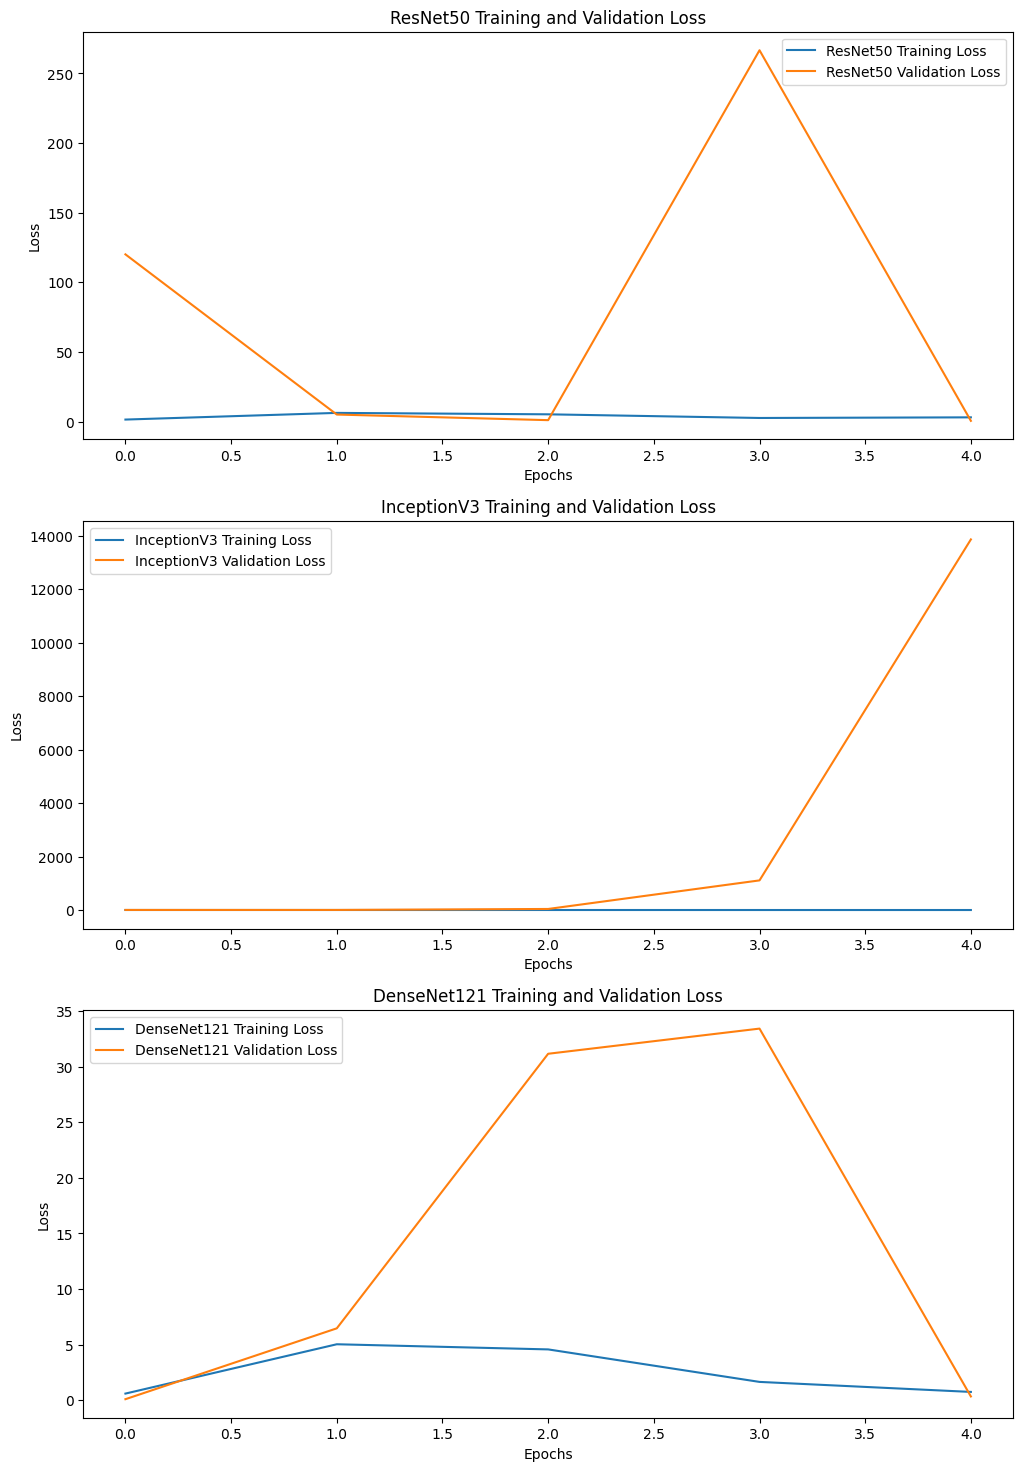

In [9]:
# Function to load and preprocess stock data
def load_and_preprocess_stock_data(symbol, start_date, end_date):
    data = pd.read_csv(f'archive/stocks/{symbol}.csv')
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data[start_date:end_date]

    # Normalizing the close prices
    scaler = MinMaxScaler()
    data['Close'] = scaler.fit_transform(data[['Close']])

    return data[['Close']], scaler

# Function to re-train and save models, returning the history object
def retrain_and_save_model(base_model, model_name, X_train, y_train):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[early_stopping, checkpoint])
    
    # Save the model
    model.save(f'{model_name}.keras')

    return history

# Function to train models and plot loss/accuracy
def train_and_evaluate(symbol, start_date, end_date):
    data, scaler = load_and_preprocess_stock_data(symbol, start_date, end_date)
    X_train = np.array(data.index).reshape(-1, 1)
    y_train = data['Close'].values

    # Generate synthetic image data for training
    X_train_synthetic = np.random.rand(len(X_train), 224, 224, 3)

    # Load base models
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    # Re-train and save each model
    resnet_history = retrain_and_save_model(resnet_base, 'resnet50_stock_model', X_train_synthetic, y_train)
    inception_history = retrain_and_save_model(inception_base, 'inceptionv3_stock_model', X_train_synthetic, y_train)
    densenet_history = retrain_and_save_model(densenet_base, 'densenet121_stock_model', X_train_synthetic, y_train)

    # Plot the training and validation loss for each model
    fig, ax = plt.subplots(3, 1, figsize=(12, 18))

    # ResNet50
    ax[0].plot(resnet_history.history['loss'], label='ResNet50 Training Loss')
    ax[0].plot(resnet_history.history['val_loss'], label='ResNet50 Validation Loss')
    ax[0].set_title('ResNet50 Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # InceptionV3
    ax[1].plot(inception_history.history['loss'], label='InceptionV3 Training Loss')
    ax[1].plot(inception_history.history['val_loss'], label='InceptionV3 Validation Loss')
    ax[1].set_title('InceptionV3 Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    # DenseNet121
    ax[2].plot(densenet_history.history['loss'], label='DenseNet121 Training Loss')
    ax[2].plot(densenet_history.history['val_loss'], label='DenseNet121 Validation Loss')
    ax[2].set_title('DenseNet121 Training and Validation Loss')
    ax[2].set_xlabel('Epochs')
    ax[2].set_ylabel('Loss')
    ax[2].legend()

    plt.show()

# Example usage:
train_and_evaluate('ZS', '2020-01-01', '2020-04-01')


### Converting from a GIF to an MP4

This is useful if you want to manually test a video of the stock market in our application instead of automatically doing it

In [10]:
# Function to extract frames from GIF
def extract_frames(gif_path, output_folder):
    gif = Image.open(gif_path)
    frame_count = 0

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    while True:
        frame_path = os.path.join(output_folder, f"frame_{frame_count:03d}.png")
        gif.save(frame_path, 'PNG')
        frame_count += 1

        try:
            gif.seek(gif.tell() + 1)
        except EOFError:
            break

    return output_folder, frame_count

# Function to create MP4 from frames
def create_video_from_frames(output_folder, output_video_path, fps=10):
    images = [img for img in os.listdir(output_folder) if img.endswith(".png")]
    images.sort()

    if not images:
        raise ValueError("No frames found in the output folder")

    # Determine the width and height from the first image
    first_frame = cv2.imread(os.path.join(output_folder, images[0]))
    height, width, layers = first_frame.shape

    video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        frame = cv2.imread(os.path.join(output_folder, image))
        video.write(frame)

    video.release()

# Paths
gif_path = './trading_animation.gif'
output_folder = 'gif_frames'
output_video_path = 'trading_animation.mp4'

# Extract frames
extract_frames(gif_path, output_folder)

# Create video
create_video_from_frames(output_folder, output_video_path)

print(f"Conversion complete: {output_video_path}")


Conversion complete: trading_animation.mp4


### Pre-Trained Models Ensembled together shown on Gradio

This interface allows users to predict stock prices using an ensemble of pre-trained models: ResNet50, InceptionV3, and DenseNet121. The models are fine-tuned to analyze historical stock data and generate predictions that can guide trading decisions. The three pre -trained models are ensembled together and then using majority voting, are used to calculated the capital of the stock market at the end of its time range.

In [ ]:
def update_date_range(symbol):
    filename = f"{symbol}.csv"
    data_path = os.path.join('archive', 'stocks', filename)
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    available_start_date = df['Date'].min().date()
    available_end_date = df['Date'].max().date()
    return f"Available date range for {symbol}: {available_start_date} to {available_end_date}"

def train_and_return_history(model, X_train, y_train):
    history = model.fit(
        X_train, y_train, epochs=5, validation_split=0.2,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )
    return history

def build_resnet_model():
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = resnet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=resnet_base.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
    return model

def build_inception_model():
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = inception_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=inception_base.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
    return model

def build_densenet_model():
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    x = densenet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='linear')(x)
    model = Model(inputs=densenet_base.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])
    return model

def predict_stock_prices_with_ensemble(symbol, initial_capital, start_date, end_date):
    # Load and prepare the data
    filename = f"{symbol}.csv"
    data_path = os.path.join('archive', 'stocks', filename)
    df = pd.read_csv(data_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df = df[start_date:end_date]

    # Normalize the Close prices
    close_scaler = MinMaxScaler()
    df['Close'] = close_scaler.fit_transform(df[['Close']])

    # Synthetic data to simulate model training
    X_train_synthetic = np.random.rand(100, 224, 224, 3)  # Example synthetic data
    y_train = np.random.rand(100)

    # Build models and get their histories
    resnet_model = build_resnet_model()
    inception_model = build_inception_model()
    densenet_model = build_densenet_model()

    resnet_history = train_and_return_history(resnet_model, X_train_synthetic, y_train)
    inception_history = train_and_return_history(inception_model, X_train_synthetic, y_train)
    densenet_history = train_and_return_history(densenet_model, X_train_synthetic, y_train)

    # Combine predictions by averaging
    predictions = {
        "ResNet50": resnet_model.predict(X_train_synthetic).flatten(),
        "InceptionV3": inception_model.predict(X_train_synthetic).flatten(),
        "DenseNet121": densenet_model.predict(X_train_synthetic).flatten(),
    }
    predictions["Ensemble"] = np.mean([predictions["ResNet50"], predictions["InceptionV3"], predictions["DenseNet121"]], axis=0)

    # Final capital calculations based on ensemble predictions
    def calculate_final_capital(predictions, initial_capital):
        cash = initial_capital
        stocks = 0
        for i in range(1, len(predictions)):
            predicted_price = predictions[i]
            if predicted_price > predictions[i-1]:  # Buy condition
                if cash > 0:
                    stocks = cash / predicted_price
                    cash = 0
            elif predicted_price < predictions[i-1]:  # Sell condition
                if stocks > 0:
                    cash = stocks * predicted_price
                    stocks = 0
        final_capital = cash + stocks * predictions[-1]
        return final_capital

    resnet_capital = calculate_final_capital(predictions["ResNet50"], initial_capital)
    inception_capital = calculate_final_capital(predictions["InceptionV3"], initial_capital)
    densenet_capital = calculate_final_capital(predictions["DenseNet121"], initial_capital)
    ensemble_capital = calculate_final_capital(predictions["Ensemble"], initial_capital)

    # Load the pre-existing GIF
    gif_path = "trading_animation.gif"

    # Plot results for ResNet50
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(resnet_history.history['loss'], label='Training Loss')
    ax1.plot(resnet_history.history['val_loss'], label='Validation Loss')
    ax1.set_title('ResNet50: Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(resnet_history.history['accuracy'], label='Training Accuracy')
    ax2.plot(resnet_history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('ResNet50: Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()

    # Plot results for InceptionV3
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 6))
    ax3.plot(inception_history.history['loss'], label='Training Loss')
    ax3.plot(inception_history.history['val_loss'], label='Validation Loss')
    ax3.set_title('InceptionV3: Training and Validation Loss')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.legend()

    ax4.plot(inception_history.history['accuracy'], label='Training Accuracy')
    ax4.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
    ax4.set_title('InceptionV3: Training and Validation Accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')
    ax4.legend()

    plt.tight_layout()

    # Plot results for DenseNet121
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(12, 6))
    ax5.plot(densenet_history.history['loss'], label='Training Loss')
    ax5.plot(densenet_history.history['val_loss'], label='Validation Loss')
    ax5.set_title('DenseNet121: Training and Validation Loss')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Loss')
    ax5.legend()

    ax6.plot(densenet_history.history['accuracy'], label='Training Accuracy')
    ax6.plot(densenet_history.history['val_accuracy'], label='Validation Accuracy')
    ax6.set_title('DenseNet121: Training and Validation Accuracy')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Accuracy')
    ax6.legend()

    plt.tight_layout()

    # Plot results for Ensemble
    fig4, ax7 = plt.subplots(figsize=(12, 6))
    epochs = range(1, 6)
    ax7.plot(epochs, resnet_history.history['val_loss'], label='ResNet50 Validation Loss')
    ax7.plot(epochs, inception_history.history['val_loss'], label='InceptionV3 Validation Loss')
    ax7.plot(epochs, densenet_history.history['val_loss'], label='DenseNet121 Validation Loss')
    ax7.set_title('Ensemble: Validation Loss per Model')
    ax7.set_xlabel('Epochs')
    ax7.set_ylabel('Loss')
    ax7.legend()

    return fig1, fig2, fig3, fig4, resnet_capital, inception_capital, densenet_capital, ensemble_capital, gif_path

# Get the list of available CSV files
available_symbols = [f.split('.')[0] for f in os.listdir('archive/stocks') if f.endswith('.csv')]

with gr.Blocks() as iface:
    symbol_input = gr.Dropdown(label="Stock Ticker Symbol", choices=available_symbols, interactive=True, allow_custom_value=True)
    date_range_output = gr.Textbox(label="Available Date Range", interactive=False)
    initial_capital_input = gr.Number(label="Initial Capital", value=10000, step=100)
    start_date_input = gr.Textbox(label="Start Date (YYYY-MM-DD)")
    end_date_input = gr.Textbox(label="End Date (YYYY-MM-DD)")
    gif_output = gr.Image(type="filepath")
    resnet_capital_output = gr.Textbox(label="ResNet50 Model Capital", interactive=False)
    inception_capital_output = gr.Textbox(label="InceptionV3 Model Capital", interactive=False)
    densenet_capital_output = gr.Textbox(label="DenseNet121 Model Capital", interactive=False)
    final_capital_output = gr.Textbox(label="Final Capital (Ensemble Model)", interactive=False)
    resnet_plot_output = gr.Plot(label="ResNet50: Training and Validation")
    inception_plot_output = gr.Plot(label="InceptionV3: Training and Validation")
    densenet_plot_output = gr.Plot(label="DenseNet121: Training and Validation")
    ensemble_plot_output = gr.Plot(label="Ensemble: Validation")

    symbol_input.change(
        fn=update_date_range,
        inputs=symbol_input,
        outputs=date_range_output
    )

    predict_button = gr.Button("Predict")
    predict_button.click(
        fn=predict_stock_prices_with_ensemble,
        inputs=[symbol_input, initial_capital_input, start_date_input, end_date_input],
        outputs=[
            resnet_plot_output,
            inception_plot_output,
            densenet_plot_output,
            ensemble_plot_output,
            resnet_capital_output,
            inception_capital_output,
            densenet_capital_output,
            final_capital_output,
            gif_output  # This will display the existing GIF
        ]
    )

iface.launch(share=True)


Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://2bc220cdb6581b5696.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0000e+00 - loss: 2.7761 - val_accuracy: 0.0000e+00 - val_loss: 2.9128
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0000e+00 - loss: 1.8824 - val_accuracy: 0.0000e+00 - val_loss: 1151.5131
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0000e+00 - loss: 5.5571 - val_accuracy: 0.0000e+00 - val_loss: 101971.3594
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0000e+00 - loss: 3.0250 - val_accuracy: 0.0000e+00 - val_loss: 562.0316
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0000e+00 - loss: 0.6601 - val_accuracy: 0.0000e+00 - val_loss: 268006.2812
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.0000e+00 - loss: 1.0403 - val_accuracy: 0.0000e+00 - val_loss: 16.4988
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 766ms/step - accuracy: 0.0000e+00 - loss: 0.8002 - val_accuracy: 0.0000e+00 - val_loss: 12.4123
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 705ms/step - accuracy: 0.0000e

c:\Users\Ranjot Sandhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0465 - val_loss: 0.0358
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0250 - val_loss: 0.1191
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0240 - val_loss: 0.0745
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202 - val_loss: 0.0593
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0178 - val_loss: 0.0862
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0145 - val_loss: 0.0546
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0119 - val_loss: 0.0643
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - val_loss: 0.0556
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - val_loss: 0.0563
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_loss: 0.0517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/